In [1]:
from os.path import join
from itertools import chain

import numpy as np
from numpy.linalg import svd
from scipy.io import loadmat

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [2]:
def loadfaces(path):
    """
    faces is an array of the flattened images one per column with repeats indicated by 'nfaces' of each person 
    (m, n) is the shape of individual images (need to transpose to get them correctly oriented)
    but they are returned as flattened vectors of length 192x168 = 32256 
    nfaces is a list of the number of images for each person (varies slightly) so can be used as a 'stride'
    between individuals
    """
    contents = loadmat(path)
    faces = contents['faces']
    m, n = [int(contents[k]) for k in ['m', 'n']]
    nfaces = contents['nfaces'][0]
    return faces, m, n, nfaces

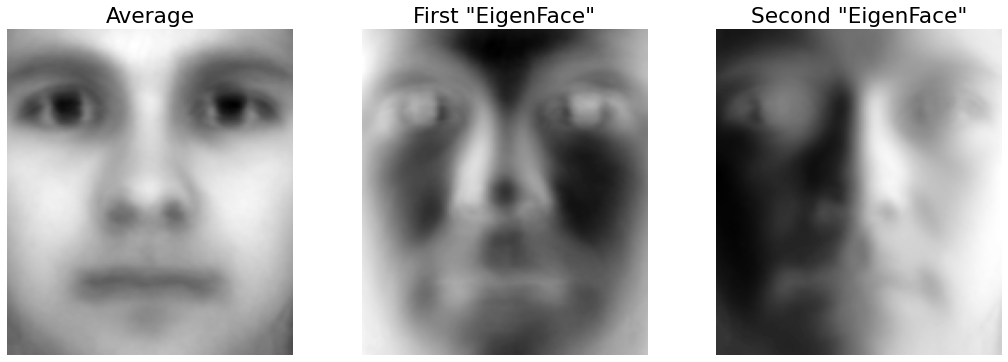

In [3]:
faces, m, n, nfaces = loadfaces(join('..', 'DATA', 'allFaces.mat'))

# We use the first 36 people for training data
training_faces = faces[:, :sum(nfaces[:36])]
average_face = training_faces.mean(axis=1) # length n*m

# Compute eigenfaces on mean-subtracted training data
X = training_faces - average_face[:, np.newaxis]
U, S, VT = svd(X, full_matrices=False)

# Display some eigenfaces
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
derived_faces = [average_face, U[:, 0], U[:, 1]]
titles = ['Average', 'First "EigenFace"', 'Second "EigenFace"']
for ax, face, title in zip(axs, derived_faces, titles):
    ax.imshow(face.reshape((m, n)).T, cmap='gray')
    ax.axis(False)
    ax.set_title(title)

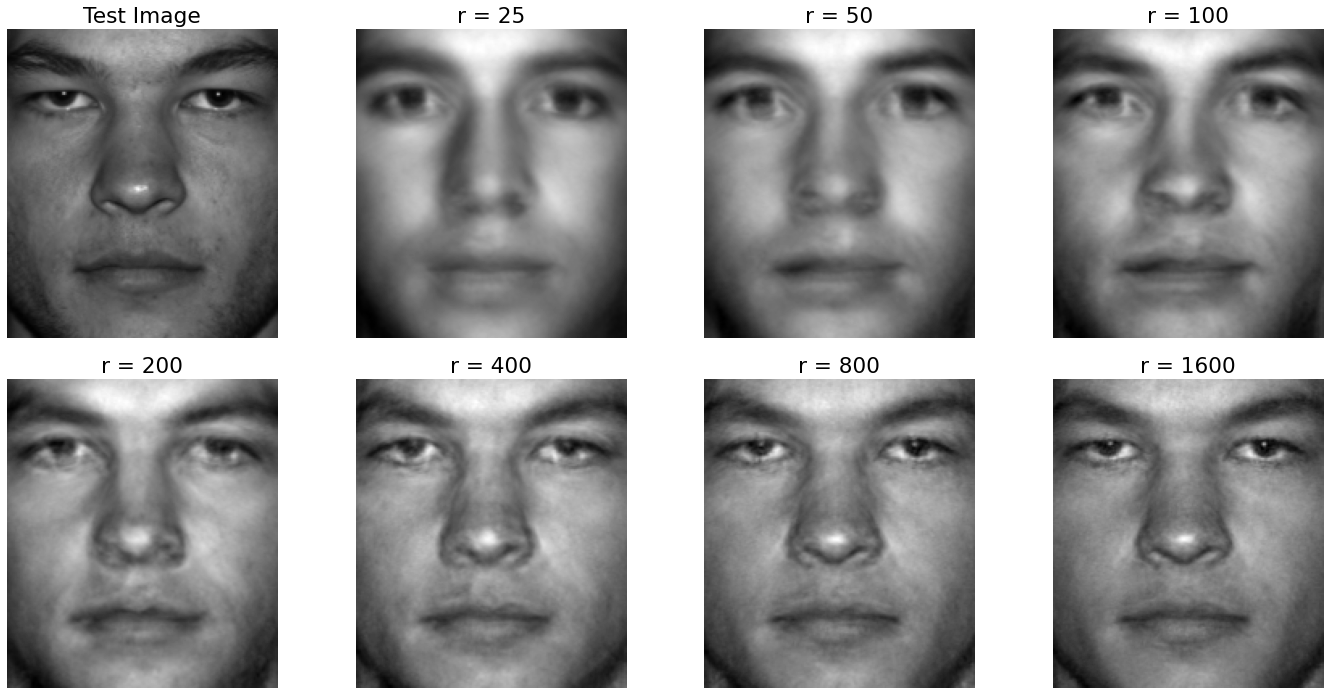

In [4]:
# Figure 1.18

## Now show eigenface reconstruction of image that was omitted from test set
# First face of person 37
test_face = faces[:, sum(nfaces[:36])]
test_face_centred = test_face - average_face

rs = [25, 50, 100, 200, 400, 800, 1600]
recon_faces = (
    average_face + U[:, :r] @ (U[:, :r].T @ test_face_centred)
    for r in rs
)
all_faces = (face.reshape((m, n)).T for face in chain([test_face], recon_faces))

titles = ['Test Image'] + [f'r = {r}' for r in rs]

ncols = 4
nrows = (1 + len(rs)) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
for ax, face, title in zip(axs.flat, all_faces, titles):
    ax.imshow(face, cmap='gray')
    ax.set_title(title)
    ax.axis(False)
plt.tight_layout();

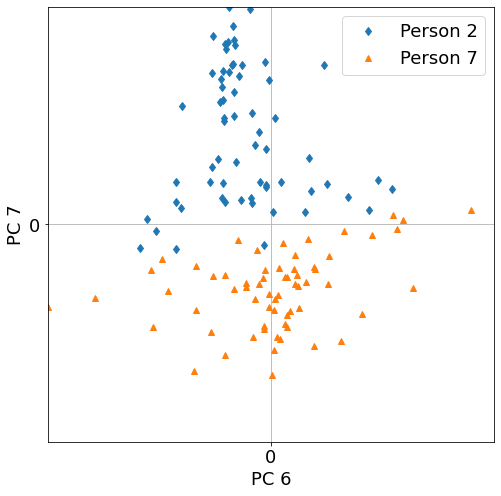

In [5]:
# Figure 1.21

## Project person 2 and 7 onto PC6 and PC7

pa_ind = 2 # Person number 2
pa_start = sum(nfaces[:(pa_ind - 1)])
pa_stop = pa_start + nfaces[pa_ind]
pa_slice = slice(pa_start, pa_stop)
pa_faces = faces[:, pa_slice] - average_face[:, np.newaxis]

pb_ind = 7 # Person number 7
pb_start = sum(nfaces[:(pb_ind - 1)])
pb_stop = pb_start + nfaces[pb_ind]
pb_slice = slice(pb_start, pb_stop)
pb_faces = faces[:, pb_slice] - average_face[:, np.newaxis]

pca_modes = np.array([5, 6])
pca_coords_pa = U[:, pca_modes - 1].T @ pa_faces
pca_coords_pb = U[:, pca_modes - 1].T @ pb_faces

fig, ax = plt.subplots(figsize=(8, 8))
xlim = max(abs(pca_coords_pa[0]).max(), abs(pca_coords_pb[0]).max())
ylim = max(abs(pca_coords_pa[1]).max(), abs(pca_coords_pb[1]).max())
ax.plot(pca_coords_pa[0], pca_coords_pa[1], 'd', label='Person 2')
ax.plot(pca_coords_pb[0], pca_coords_pb[1], '^', label='Person 7')
ax.set_xlabel('PC 6')
ax.set_ylabel('PC 7')
ax.set_xlim([-xlim, xlim])
ax.set_ylim([-ylim, ylim])
ax.set_xticks([0])
ax.set_yticks([0])

ax.legend()
ax.grid(True);